# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
# %pip install sentencepiece

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
import torch
import numpy as np
from dataset import TextDataset
from train import train
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
"pad_id =", train_set.pad_id, "unk_id =", train_set.unk_id, "bos_id =", train_set.bos_id, "eos_id =", train_set.eos_id

('pad_id =', 0, 'unk_id =', 1, 'bos_id =', 2, 'eos_id =', 3)

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(500):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1, indices

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length, 'err'

In [ ]:
for _ in range(1):
        indices, length = train_set[np.random.randint(len(dataset))]

        a = train_set.ids2text(ids=indices)
        print(a)

- воспитай в себе одну очень хорошую черту характера - никогда не выясняй отношения с людьми, которые тебя разочаровали. просто молча оставь их вместе со всем их дерьмом наедине и уходи.- петрович, по-соседски прошу, почини канализацию!


## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [ ]:
from model import LanguageModel

In [ ]:
model = LanguageModel(train_set, hidden_size=256, embed_size=256)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, train_set.max_length, train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [ ]:
model.to('cuda' if torch.cuda.is_available() else 'cpu')

LanguageModel(
  (drop): Dropout(p=0.3, inplace=False)
  (RNN): RNN(256, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2000, bias=True)
  (Embed): Embedding(2000, 256, padding_idx=0)
)

In [ ]:
model.inference(prefix='однажды вечером', temp=10, top_k=30)

'однажды вечером вранула затоский рабоновичмоби уди жене возраом кух стелонемудуматовхожу насто проб влади даже меся мини всчь написа мужительэ ад спро осовер зучный всемжи отли исторетифо неолли зде 5 летсла пара нашипоены мужик женеровавут чув кударядне побе подума юриа глаотлееслезм уста почению нео дво красвран будешь живыхть разнеон ониможно подходит чустычина алкоговодьятики уда ведь особен чай нашейсу отец угога занягой хоростви настоя подру люблю нобен вста сказалтьчер можешь всегда ад недо кудакономиц неда'

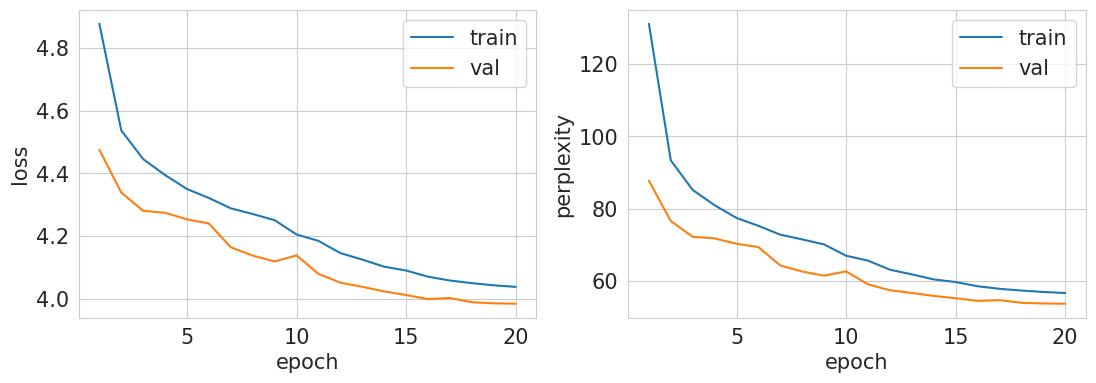

Generation examples:
однажды вечером, а когда он находит мужик на работу.
однажды вечером на улице, на улице. а если я не люблю. я не могу понять.
однажды вечером в постели. а вы что делали в порядке, то он не сможет.
однажды вечером домой, а не наблюдал, а я не знаю, как она, а то у меня нет, это все время проведет, а у меня есть еще, и он уже давно принимают нервы, то, что я в ней.
однажды вечером приходит домой в гости к своему парню- а ты, когда я вам не знаю!- почему?- да, в чем же выполнении.- так, что я?- не знаю, сынок, а кто не хочешь?


In [ ]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=16, shuffle=True)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim, T_max=20)

train(model, optim, sch, train_dataloader, valid_dataloader, 20)

In [ ]:
torch.save(model, f='RNN_2000')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

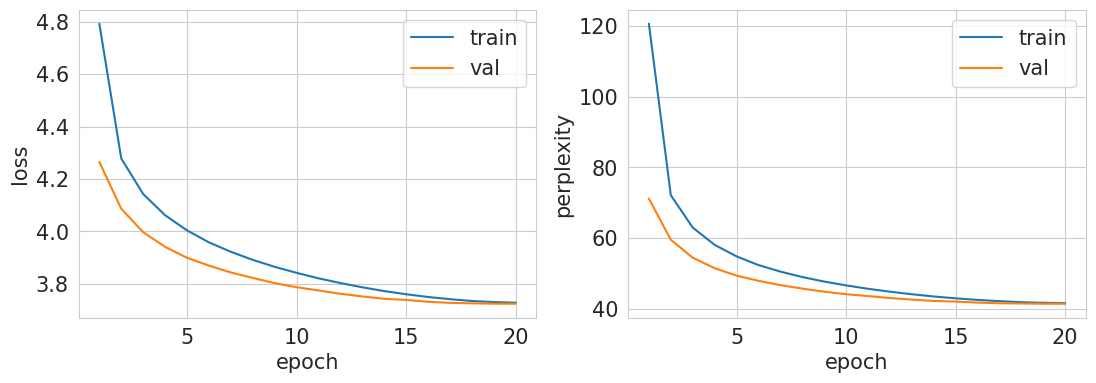

Generation examples:
однажды вечером с утра не доволся в магазин за хлебом, а не продолжается- у него в жопе.
однажды вечером на работу, в постели - мужу, уходи с женой по квартире и говорит- да, а я в автобусе с работы в твоей жизни.- но не понадвигаю.
однажды вечером придумал на посту-каундиор и не пошла на свете. я иду, не знаю как я, как повесил, чтобы выпить за него замуж!
однажды вечером я решил сделать завосточных девушек. на самого-во- что это?- ты знаешь, как ты думаешь, когда я буду надеться в постели?- я не понимаю, а я с женой по утрам.
однажды вечером с девушкой. жена- у вас есть двери?- да нет, я хочу сдавать!


In [ ]:
model2 = LanguageModel(train_set, rnn_type=nn.LSTM, hidden_size=256, embed_size=256)
model2.to('cuda' if torch.cuda.is_available() else 'cpu')

optim2 = torch.optim.AdamW(model2.parameters(), lr=1e-3)
sch2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim2, T_max=20)

train(model2, optim2, sch2, train_dataloader, valid_dataloader, 20)

In [ ]:
torch.save(model2, f='LSTM_2000')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
for t in np.arange(1e-6, 5, 0.1):
  print(model.inference(prefix='Штирлиц говорил', temp=t, top_k=5))
  print(model2.inference(prefix='Штирлиц говорил', temp=t, top_k=5))

штирлиц говорил, что у меня в россии - это когда-то не было.
штирлиц говорил, что в россии не было, а в россии.
штирлиц говорил что-то вкусный, но не забудь.
штирлиц говорил, что в россии не было, а в россии все равно не будет.
штирлиц говорил, что он не знает, что у меня нет.
штирлиц говорил мюллер. мюллер вышел из дома, а потом понял, что он не смог.
штирлиц говорил, что у меня в россии, что вы не можете, чтобы он не смогутить, что он не любит.
штирлиц говорил, что у него на работе, а в россии, а не поедет.
штирлиц говорил уточную машину и говорит- а почему у вас есть?- а что такое?- а что вы?- да, но я не знаю, что я не могу.
штирлиц говорил, что он не смог заставить себя в поисках.
штирлиц говорил в гости, и не забудь, чтобы выбирать на работу.
штирлиц говорил, что он не смог пройти с вами.
штирлиц говорил, что у меня в россии есть, а не внутренний мир.
штирлиц говорил, что у него в кабинетах.
штирлиц говорил, что я не могу понять, что это не повещают, что он не задается на  ⁇ 0 ле

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

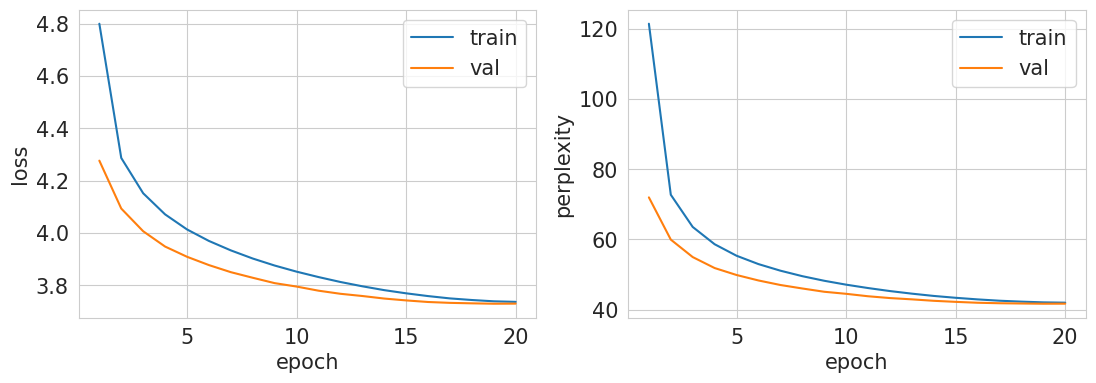

Generation examples:
однажды вечером пошла в квартире, а у меня был один другому- как у тебя дела?- неужели!
однажды вечером на улице так много, но и наступило.
однажды вечером приходит из школы домой- ну, что, ты в качестве, я тебя подушки на кухне, и ты не задай меня.
однажды вечером по улице- я тебя люблю!- а почему ты такой дурак, это еще и не было?извоню- ты же знаешь, почему в этой стране есть?
однажды вечером нашел, наступило по телевизору в каком-нибудьму- ты что, а я в школе?- в австралии. а я, и я на работе.


In [ ]:
train_set_big = TextDataset(data_file='jokes.txt', vocab_size=5000, train=True, sp_model_prefix='bpe')
valid_set_big = TextDataset(data_file='jokes.txt', vocab_size=5000, train=False, sp_model_prefix='bpe')

train_dataloader_big = DataLoader(train_set_big, batch_size=16, shuffle=True)
valid_dataloader_big = DataLoader(valid_set_big, batch_size=16, shuffle=True)

model_big = LanguageModel(train_set, rnn_type=nn.LSTM, hidden_size=256, embed_size=256)
model_big.to('cuda' if torch.cuda.is_available() else 'cpu')

optim_big = torch.optim.AdamW(model_big.parameters(), lr=1e-3)
sch_big = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim_big, T_max=20)

train(model_big, optim_big, sch_big, train_dataloader_big, valid_dataloader_big, 20)
torch.save(model_big, f='LSTM_5000')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
model_big = torch.load('/content/LSTM_5000', weights_only=False)
model_big.eval()
infer_set = []
for _ in range(len(valid_set)):
  infer_set.append(model_big.inference())

In [ ]:
with open('infer.txt', 'w', encoding='utf-8') as f:
    for sentence in infer_set:
        f.write(sentence + '\n')

In [ ]:
t = []
for i in range(len(valid_set)):
  indices, length = valid_set[i]
  t.append(valid_set.ids2text(indices))

with open('encode.txt', 'w', encoding='utf-8') as f:
    for sentence in t:
        f.write(sentence + '\n')

In [ ]:
with open('infer.txt', 'r', encoding='utf-8') as f1, \
     open('encode.txt', 'r', encoding='utf-8') as f2, \
     open('combined.txt', 'w', encoding='utf-8') as out_file:

    out_file.write(f1.read())
    out_file.write(f2.read())

In [ ]:
with open('combined.txt', 'r', encoding='utf-8') as combo:
  text = []
  for line in combo:
    text.append(line)
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=None,
    ngram_range=(1, 1),
    min_df=1,
    max_df=1.0,
    use_idf=True,
    smooth_idf=True
)

tfidf_matrix = vectorizer.fit_transform(text)

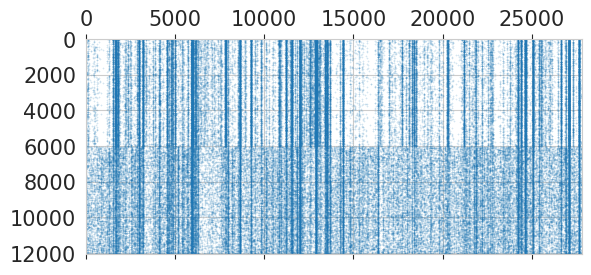

In [ ]:
import matplotlib.pyplot as plt
plt.spy(tfidf_matrix, markersize=0.1, alpha=0.5)

plt.show()

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

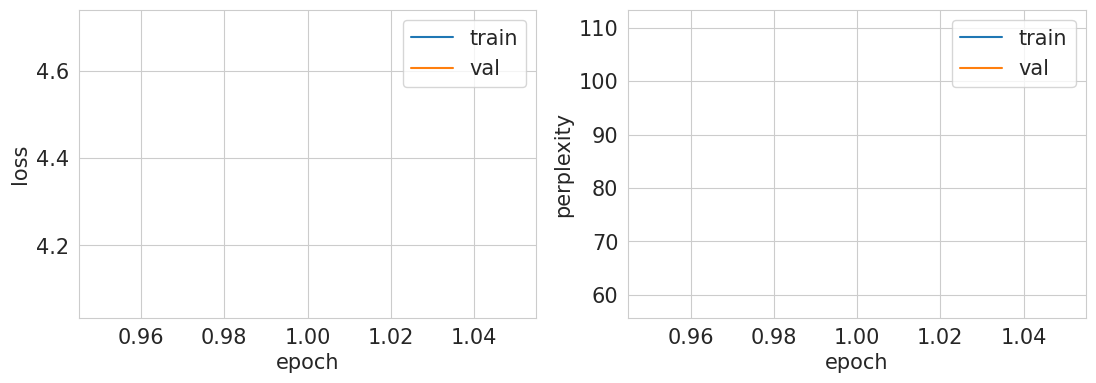

Generation examples:


AttributeError: 'GPT2LMHeadModel' object has no attribute 'inference'

In [ ]:
# Load model directly
from train_ru import train as train_ru
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
model_ru = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
model_ru.to('cuda' if torch.cuda.is_available() else 'cpu')

train_set_ru = TextDataset(data_file='jokes.txt', vocab_size=5000, train=True, sp_model_prefix='bpe')
valid_set_ru = TextDataset(data_file='jokes.txt', vocab_size=5000, train=False, sp_model_prefix='bpe')

train_dataloader_ru = DataLoader(train_set_ru, batch_size=16, shuffle=True)
valid_dataloader_ru = DataLoader(valid_set_ru, batch_size=16, shuffle=True)

optim_ru = torch.optim.AdamW(model_ru.parameters(), lr=1e-3)
sch_ru = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim_ru, T_max=20)

train_ru(model_ru, optim_ru, sch_ru, train_dataloader_ru, valid_dataloader_ru, 1)

In [ ]:
torch.save(model_ru, f='ruGPT')

In [ ]:
def complete_sentence(prompt: str, max_new_tokens: int = 50) -> str:
    ids = valid_set_ru.text2ids(prompt)           # твой список токенов
    input_ids = torch.tensor([ids]).to(model_ru.device)
    output_ids = model_ru.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.8,
        top_k=50,
        temperature=1.0,
        repetition_penalty=1.2,
    )
    text = valid_set_ru.ids2text(output_ids[0])
    # оставляем только до конца первого предложения
    for end in [".", "!", "?"]:
        idx = text.find(end, len(prompt))
        if idx != -1:
            return text[:idx+1]
    return text
for i in range(10):
  print(complete_sentence("Штирлиц говорил"))

штирлиц говорил что-то отмечали, и запомнился и подумал, не дармец.
штирлиц говорил мюллеру напился, посмотри в кармане.
штирлиц говорил мюллер, заведу с кухни.
штирлиц говорил, подумал в барабана с попытки.
штирлиц говорил отошел и как-то пожимал болею, мюллер.
штирлиц говорил штирлиц по ситу.
штирлиц говорил, что и не огурецкала.
штирлиц говорил мюллер, подумал штирлиц.
штирлиц говорил как пишу на угрюм? подумал.
штирлиц говорил, что всей и в камере учистке.


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.